In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize, CenterCrop, Compose
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Performance optimization: use medium precision for float32 matmul
# This can improve performance on modern GPUs with minimal precision loss
torch.set_float32_matmul_precision('medium')

# Constants for converting lat/lon to meters (approximate, valid for small areas)
# At Washington DC latitude (~38.9°N)
METERS_PER_DEG_LAT = 111_000  # ~111 km per degree latitude
METERS_PER_DEG_LON = 86_500   # ~86.5 km per degree longitude at 38.9°N

def euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon):
    """
    Calculate approximate Euclidean distance in meters between coordinates.
    Valid for small areas where Earth's curvature is negligible.
    """
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    return torch.sqrt(dlat_m**2 + dlon_m**2)

In [ ]:
class GlobalStreetscapesRegression(Dataset):
    def __init__(self, dataset, lat_mean, lat_std, lon_mean, lon_std):
        self.img_labels = dataset
        # Resize the *shorter* side to 224 first, then center-crop to 224×224
        self.transform = Compose([
            Resize(224),
            CenterCrop(224)
        ])
        # Store normalization parameters
        self.lat_mean = lat_mean
        self.lat_std = lat_std
        self.lon_mean = lon_mean
        self.lon_std = lon_std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        image = self.transform(image)
        
        # Get coordinates and normalize them
        lat = self.img_labels.iloc[idx].loc["lat"]
        lon = self.img_labels.iloc[idx].loc["lon"]
        
        # Normalize coordinates (important for regression stability)
        lat_norm = (lat - self.lat_mean) / self.lat_std
        lon_norm = (lon - self.lon_mean) / self.lon_std
        
        coords = torch.tensor([lat_norm, lon_norm], dtype=torch.float32)
        return image, coords

In [ ]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:", samples.shape[0])
print("paths rows:", paths.shape[0])
print("img_labels rows:", img_labels.shape[0])

# Calculate normalization parameters from training data BEFORE splitting
# This ensures consistent normalization across train/test
lat_mean = img_labels['lat'].mean()
lat_std = img_labels['lat'].std()
lon_mean = img_labels['lon'].mean()
lon_std = img_labels['lon'].std()

print(f"\nCoordinate statistics:")
print(f"Lat - Mean: {lat_mean:.6f}, Std: {lat_std:.6f}")
print(f"Lon - Mean: {lon_mean:.6f}, Std: {lon_std:.6f}")

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, random_state=42)

display(train_df.head())

training_data = GlobalStreetscapesRegression(
    train_df, lat_mean, lat_std, lon_mean, lon_std
)

test_data = GlobalStreetscapesRegression(
    test_df, lat_mean, lat_std, lon_mean, lon_std
)

# Store normalization params for later use
norm_params = {
    'lat_mean': lat_mean,
    'lat_std': lat_std,
    'lon_mean': lon_mean,
    'lon_std': lon_std
}

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

samples rows: 47527
paths rows: 89741
img_labels rows: 44605


,uuid,source,orig_id,city_lat,city_lon,city,country,count_per_country,iso3,label,path
43009,d733b70a-82ec-4451-9a65-d68f83edc977,Mapillary,4.361211e+14,25.0478,121.5319,Taipei,Taiwan,9389,TWN,3,../data/imgs/40001_47527/d733b70a-82ec-4451-9a...
35003,abe2bd0e-80a7-4d54-b0e8-4ba625c816dc,Mapillary,5.298856e+14,47.4983,19.0408,Budapest,Hungary,9339,HUN,1,../data/imgs/30001_40000/abe2bd0e-80a7-4d54-b0...
24961,d17dad79-809e-49a9-ae5e-c0de373e5e0d,Mapillary,9.481359e+14,38.9047,-77.0163,Washington,United States,9677,USA,4,../data/imgs/20001_30000/d17dad79-809e-49a9-ae...
24484,26ef71a1-e357-4db2-9b69-2077697e6c8c,Mapillary,1.902852e+14,38.9047,-77.0163,Washington,United States,9677,USA,4,../data/imgs/20001_30000/26ef71a1-e357-4db2-9b...
44817,6b794da8-5d0c-485c-8312-92d8b0219045,Mapillary,7.935113e+14,25.0478,121.5319,Taipei,Taiwan,9389,TWN,3,../data/imgs/40001_47527/6b794da8-5d0c-485c-83...


Taipei


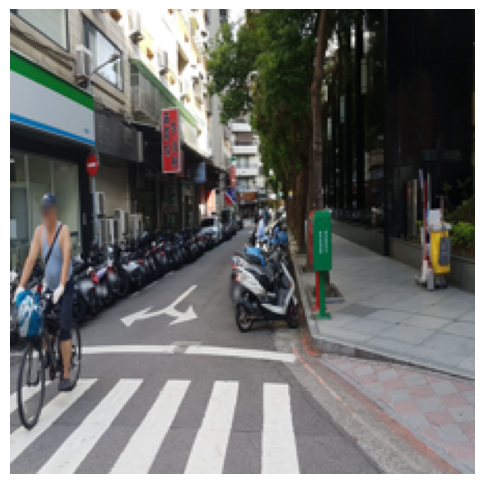

In [ ]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
lat = training_data.img_labels.iloc[10].loc["lat"]
lon = training_data.img_labels.iloc[10].loc["lon"]
print(f"City: {training_data.img_labels.iloc[10].loc['city']}")
print(f"Coordinates: ({lat:.6f}, {lon:.6f})")

img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6, 10))
plt.imshow(img)
plt.title(f"Lat: {lat:.6f}, Lon: {lon:.6f}")
plt.axis("off")
plt.show()

In [ ]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html
weights = ViT_B_16_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_b_16(weights=weights)

in_features = model.heads.head.in_features

# Replace the classification head with a regression head (2 outputs: lat, lon)
print(f"Previous head: {model.heads.head}")
model.heads.head = nn.Sequential(
    nn.Linear(in_features=in_features, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(in_features=256, out_features=2)  # 2 outputs: lat, lon
)
print(f"New head: {model.heads.head}")

model = model.to(device=device)

# Compile model for better performance using CUDA graphs instead of context switching
# This optimization can significantly reduce training time
model = torch.compile(model)

print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 297MB/s] 


Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=5, bias=True)
Number of classes: 5
Using device: cuda


In [ ]:
# Configuration
num_epochs = 5
checkpoint_path = None  # Set to a .pth file path to resume training, e.g., 'vit_b_16_regression_epoch2.pth'

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)  # Lower LR for regression
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Use MSE loss for normalized coordinates during training
mse_criterion = nn.MSELoss()

# Load checkpoint if specified
start_epoch = 0
if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    norm_params = checkpoint.get('norm_params', norm_params)
    print(f"Resuming from epoch {start_epoch}")
elif checkpoint_path:
    print(f"Checkpoint {checkpoint_path} not found. Starting from scratch.")


EPOCH: 1


  0%|          | 0/558 [00:00<?, ?it/s]

Loss: 1.396 (1.396)
EPOCH: 2


  0%|          | 0/558 [00:00<?, ?it/s]

Loss: 0.865 (1.131)
EPOCH: 3


  0%|          | 0/558 [00:00<?, ?it/s]

Loss: 0.655 (0.972)
EPOCH: 4


  0%|          | 0/558 [00:00<?, ?it/s]

Loss: 0.566 (0.871)
EPOCH: 5


  0%|          | 0/558 [00:00<?, ?it/s]

Loss: 0.495 (0.796)


In [ ]:

# Training loop
train_losses = []
val_distances = []

for epoch in range(start_epoch, start_epoch + num_epochs):
    print(f"\nEPOCH: {epoch + 1}")

    # Training phase
    current_loss = 0
    model.train()
    for inputs, coords in tqdm(train_dataloader, desc="Training"):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        coords = coords.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mse_criterion(outputs, coords)
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Training MSE Loss: {avg_train_loss:.6f}")
    
    # Validation phase - calculate actual distance error
    model.eval()
    total_distance = 0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, coords in tqdm(test_dataloader, desc="Validating"):
            inputs = inputs.to(device, non_blocking=True)
            coords = coords.to(device, non_blocking=True)
            
            inputs = transform(inputs)
            outputs = model(inputs)
            
            # Denormalize predictions and targets for distance calculation
            pred_lat = outputs[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
            pred_lon = outputs[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
            true_lat = coords[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
            true_lon = coords[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
            
            distances = euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon)
            total_distance += distances.sum().item()
            num_samples += coords.size(0)
    
    avg_distance = total_distance / num_samples
    val_distances.append(avg_distance)
    print(f"Validation Mean Distance Error: {avg_distance:.2f} meters")
    
    # Update learning rate scheduler
    scheduler.step(avg_distance)
    
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_distance': avg_distance,
        'norm_params': norm_params,
    }, f'vit_b_16_regression_epoch{epoch}.pth')
    print(f"Checkpoint saved: vit_b_16_regression_epoch{epoch}.pth")

In [ ]:
# Final Evaluation
model.eval()
all_distances = []
all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, coords in tqdm(test_dataloader, desc="Final Evaluation"):
        inputs = inputs.to(device, non_blocking=True)
        coords = coords.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        # Denormalize predictions and targets
        pred_lat = outputs[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
        pred_lon = outputs[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
        true_lat = coords[:, 0] * norm_params['lat_std'] + norm_params['lat_mean']
        true_lon = coords[:, 1] * norm_params['lon_std'] + norm_params['lon_mean']
        
        distances = euclidean_distance_meters(pred_lat, pred_lon, true_lat, true_lon)
        all_distances.extend(distances.cpu().numpy())
        
        # Store for visualization
        all_predictions.extend(torch.stack([pred_lat, pred_lon], dim=1).cpu().numpy())
        all_targets.extend(torch.stack([true_lat, true_lon], dim=1).cpu().numpy())

all_distances = np.array(all_distances)
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate metrics
mean_distance = np.mean(all_distances)
median_distance = np.median(all_distances)
std_distance = np.std(all_distances)
percentile_25 = np.percentile(all_distances, 25)
percentile_75 = np.percentile(all_distances, 75)
percentile_90 = np.percentile(all_distances, 90)

print("=" * 50)
print("FINAL TEST RESULTS")
print("=" * 50)
print(f"Mean Distance Error: {mean_distance:.2f} meters")
print(f"Median Distance Error: {median_distance:.2f} meters")
print(f"Std Distance Error: {std_distance:.2f} meters")
print(f"25th Percentile: {percentile_25:.2f} meters")
print(f"75th Percentile: {percentile_75:.2f} meters")
print(f"90th Percentile: {percentile_90:.2f} meters")
print(f"Min Distance Error: {np.min(all_distances):.2f} meters")
print(f"Max Distance Error: {np.max(all_distances):.2f} meters")

  0%|          | 0/140 [00:00<?, ?it/s]

Test Loss: 0.457
Test Accuracy: 83.94%


In [ ]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Training loss curve
ax1 = axes[0, 0]
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-o', label='Training MSE Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training Loss over Epochs')
ax1.legend()
ax1.grid(True)

# Plot 2: Validation distance error curve
ax2 = axes[0, 1]
ax2.plot(range(1, len(val_distances) + 1), val_distances, 'r-o', label='Validation Distance Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Distance Error (meters)')
ax2.set_title('Validation Distance Error over Epochs')
ax2.legend()
ax2.grid(True)

# Plot 3: Histogram of distance errors
ax3 = axes[1, 0]
ax3.hist(all_distances, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(mean_distance, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_distance:.1f}m')
ax3.axvline(median_distance, color='g', linestyle='--', linewidth=2, label=f'Median: {median_distance:.1f}m')
ax3.set_xlabel('Distance Error (meters)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Prediction Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Predicted vs Actual locations (scatter plot)
ax4 = axes[1, 1]
# Sample for visualization (too many points would be cluttered)
sample_size = min(1000, len(all_predictions))
idx = np.random.choice(len(all_predictions), sample_size, replace=False)

ax4.scatter(all_targets[idx, 1], all_targets[idx, 0], alpha=0.5, s=10, label='True', c='blue')
ax4.scatter(all_predictions[idx, 1], all_predictions[idx, 0], alpha=0.5, s=10, label='Predicted', c='red')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.set_title(f'Predicted vs True Locations (n={sample_size})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regression_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to 'regression_results.png'")

In [ ]:
# Visualize some individual predictions
def show_prediction(model, dataset, idx, transform, norm_params, device):
    """Show an image with its true and predicted coordinates."""
    model.eval()
    
    image, coords_norm = dataset[idx]
    
    # Get prediction
    with torch.no_grad():
        image_batch = image.unsqueeze(0).to(device)
        image_batch = transform(image_batch)
        output = model(image_batch)
    
    # Denormalize
    pred_lat = output[0, 0].item() * norm_params['lat_std'] + norm_params['lat_mean']
    pred_lon = output[0, 1].item() * norm_params['lon_std'] + norm_params['lon_mean']
    true_lat = coords_norm[0].item() * norm_params['lat_std'] + norm_params['lat_mean']
    true_lon = coords_norm[1].item() * norm_params['lon_std'] + norm_params['lon_mean']
    
    # Calculate distance (simple Euclidean approximation)
    dlat_m = (pred_lat - true_lat) * METERS_PER_DEG_LAT
    dlon_m = (pred_lon - true_lon) * METERS_PER_DEG_LON
    dist = np.sqrt(dlat_m**2 + dlon_m**2)
    
    # Display
    img_path = os.path.join("../", dataset.img_labels.iloc[idx].loc["path"])
    img = Image.open(img_path).convert("RGB")
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"True: ({true_lat:.5f}, {true_lon:.5f})\n"
              f"Pred: ({pred_lat:.5f}, {pred_lon:.5f})\n"
              f"Error: {dist:.1f} meters", fontsize=12)
    plt.axis("off")
    plt.show()
    
    return dist

# Show 5 random predictions
print("Sample Predictions:")
print("=" * 50)
for i in range(5):
    idx = np.random.randint(0, len(test_data))
    dist = show_prediction(model, test_data, idx, transform, norm_params, device)
    print(f"Sample {i+1}: Distance error = {dist:.2f} meters\n")